# Project 1

In [1]:
import numpy as np
from scipy.integrate import quad, quadrature, odeint
import matplotlib.pyplot as plt
import numba
from numba import njit

$$
d\vec{B} = \frac{\mu_0 I}{4\pi}\frac{d\vec{l}\times\vec{r}}{|\vec{r}|^3}
$$


By defining a parametrizing for the arbitrary curve:
$$
l = \vec{F}(t) = \begin{bmatrix}f_1(t)\\ f_2(t)\\ f_3(t)\end{bmatrix}
$$


thus $d\vec{l}$ is:
$$
\frac{d\vec{l}}{dt} = \begin{bmatrix}\frac{df_1(t)}{dt}\\ \frac{df_2(t)}{dt}\\ \frac{df_3(t)}{dt}\end{bmatrix}
$$


Substituting for $d\vec{l}$:
$$
\frac{d\vec{l}}{dt} \times \vec{r} = \begin{bmatrix}
   z\frac{df_2(t)}{dt} - y\frac{df_3(t)}{dt}
\\ x\frac{df_3(t)}{dt} - z\frac{df_1(t)}{dt}
\\ y\frac{df_1(t)}{dt} - x\frac{df_2(t)}{dt}
\end{bmatrix}
$$


the magnetic field of the segment $d\vec{l}$ ($d\vec{B}$):
$$
d\vec{B} = \frac{\mu_0 I}{4\pi|\vec{r}|^3}\begin{bmatrix}
   z\frac{df_2(t)}{dt} - y\frac{df_3(t)}{dt}
\\ x\frac{df_3(t)}{dt} - z\frac{df_1(t)}{dt}
\\ y\frac{df_1(t)}{dt} - x\frac{df_2(t)}{dt}
\end{bmatrix}
$$


By integrating both sides:
$$
\vec{B} = \frac{\mu_0 I}{4\pi}\begin{bmatrix}
   \int_{t_i}^{t_f}{\frac{z\frac{df_2(t)}{dt} - y\frac{df_3(t)}{dt}}{|\vec{r}|^3}}
\\ \int_{t_i}^{t_f}{\frac{x\frac{df_3(t)}{dt} - z\frac{df_1(t)}{dt}}{|\vec{r}|^3}}
\\ \int_{t_i}^{t_f}{\frac{y\frac{df_1(t)}{dt} - x\frac{df_2(t)}{dt}}{|\vec{r}|^3}}
\end{bmatrix}
$$
While computiong we will drop $(\mu_0 I/4\pi)$, and remultiply it after doing the integral.

## Calculating B-Field

The current in all examples considered bellow is assumed to be $ I = 1 A$

In [2]:
mu_0 = 1e-7

In [3]:
def derivative_5(fun, u, h):
    return (-25 * fun(u) + 48*fun(u+h) -36*fun(u+2*h) +16*fun(u+3*h) -3*fun(u+4*h))/(12*h)
@njit
def __(F, N, x):
    ans = 0
    for i in range(0, 3*N, 3):
        ans += (x[3]-x[0])*(F[i] + 3*F[i+1] + 3*F[i+2] + F[i+3])/8
    return ans

def simpson_38(F, x1, x2, N):
    x = np.linspace(x1, x2, 3*N + 1)
    # F = f(x)
    return __(F, N, x)

In [4]:
def integrated(r, lam, f1, f2, f3):
    f1_x = derivative_5(f1, lam, 0.001)
    f2_y = derivative_5(f2, lam, 0.001)
    f3_z = derivative_5(f3, lam, 0.001)
    r_1  = np.array([r[0] - f1(lam), r[1] - f2(lam), r[2] - f3(lam)])
    R2 = r_1[0]**2 + r_1[1]**2+r_1[2]**2
    return (1/np.sqrt(R2)**3)*np.array([r_1[2]*f2_y - r_1[1]*f3_z,
                                                r_1[0]*f3_z - r_1[2]*f1_x,
                                                r_1[1]*f1_x - r_1[0]*f2_y])

In [5]:
N = 1000

In [6]:
def B(pos, f1, f2, f3, lami, lamf, N, I = 1): 
    lam = np.linspace(lami, lamf, 3*N + 1)
    return I*mu_0*np.array([simpson_38(integrated(pos, lam, f1, f2, f3)[0], lami, lamf, N),
                                             simpson_38(integrated(pos, lam, f1, f2, f3)[1], lami, lamf, N),
                                             simpson_38(integrated(pos, lam, f1, f2, f3)[2], lami, lamf, N)])

## Applying the Function

### long wire

In [7]:
iwire = -100
fwire = 100
t = np.linspace(iwire, fwire, 10000)
fxwire, fywire, fzwire = lambda t: t, lambda t: 0*t, lambda t: 0*t
Bwire = lambda pos: B(pos, fxwire, fywire, fzwire, iwire, fwire, 10000)
Bwire([0, 1, 0])

array([0.00000000e+00, 0.00000000e+00, 1.99990001e-07])

### Circle

In [8]:
%matplotlib qt
icir = 0.0
fcir = 2*np.pi
t = np.linspace(icir, fcir, 1000)
fcirx, fciry, fcirz =  lambda t:np.cos(t), lambda t:np.sin(t), lambda t: 0*t
Bcircle = lambda pos:B(pos, fcirx, fciry, fcirz, icir, fcir, 100)
xcir, ycir, zcir = np.meshgrid(np.linspace(-1.1, 1.1, 7), np.linspace(-1.1, 1.1, 7), np.linspace(-1.1, 1.1, 7))
ax = plt.axes(projection = "3d")
ax.plot(fcirx(t), fciry(t), fcirz(t))
Bcir = np.zeros([3, 7, 7, 7])
for i in range(7):
    for j in range(7):
        for k in range(7):
            Bcir[0][i][j][k], Bcir[1][i][j][k], Bcir[2][i][j][k] = Bcircle(np.array([xcir[i][j][k], ycir[i][j][k], zcir[i][j][k]]))
            if np.sqrt(Bcir[0][i][j][k]**2+Bcir[1][i][j][k]**2+Bcir[2][i][j][k]**2) > 4e-6:
                Bcir[0][i][j][k], Bcir[1][i][j][k], Bcir[2][i][j][k] = 5e-6*Bcir[0][i][j][k], 5e-6*Bcir[1][i][j][k], 5e-6*Bcir[2][i][j][k]
ax.quiver(xcir, ycir, zcir, Bcir[0], Bcir[1], Bcir[2], length=400000)
plt.show()

### Apple

In [9]:
%matplotlib qt
iap = 0.0
fapple = 2*np.pi
t = np.linspace(iap, fapple, 1000)
fapx, fapy, fapz =  lambda t:np.cos(t)**2 + np.cos(t), lambda t:np.sin(t)*np.cos(t)+np.sin(t), lambda t: 0*t
Bapple = lambda pos:B(pos, fapx, fapy, fapz, iap, fapple, 100)
xap, yap, zap = np.meshgrid(np.linspace(-1, 2, 9), np.linspace(-1, 2, 9), np.linspace(-1, 2, 9))
ax = plt.axes(projection = "3d")
ax.plot(fapx(t), fapy(t), fapz(t))
Bap = np.zeros([3, 9, 9, 9])
for i in range(9):
    for j in range(9):
        for k in range(9):
            Bap[0][i][j][k], Bap[1][i][j][k], Bap[2][i][j][k] = Bapple(np.array([xap[i][j][k], yap[i][j][k], zap[i][j][k]]))
ax.quiver(xap, yap, zap, Bap[0], Bap[1], Bap[2], length=300000)
plt.show()

In [10]:
Bapple([0, 0, 0.1])

array([-1.03558885e-06, -3.49274815e-19,  7.99520479e-07])

### Small Solenoid

In [11]:
%matplotlib qt
isol = 0.0
fsol = 2*np.pi
t = np.linspace(iap, fapple, 1000)
fsolx, fsoly, fsolz =  lambda t:0.1*np.cos(100*t), lambda t:0.1*np.sin(100*t), lambda t: t/(8*np.pi)
Bsolenoid = lambda pos:B(pos, fsolx, fsoly, fsolz, isol, fsol, 1000)
xsol, ysol, zsol = np.meshgrid(np.linspace(-.15, .15, 8), np.linspace(-.15, .15, 8), np.linspace(-.01, .30, 8))
ax = plt.axes(projection = "3d")
# ax.plot(fsolx(t), fsoly(t), fsolz(t))

Bsol = np.zeros([3, 8, 8, 8])
for i in range(8):
    for j in range(8):
        for k in range(8):
            Bsol[0][i][j][k], Bsol[1][i][j][k], Bsol[2][i][j][k] = Bsolenoid(np.array([xsol[i][j][k], ysol[i][j][k], zsol[i][j][k]]))
ax.quiver(xsol, ysol, zsol, Bsol[0], Bsol[1], Bsol[2], length=300)
plt.show()

In [12]:
np.arccos(Bsolenoid([0, 0, 0.01])[2]/np.linalg.norm(Bsolenoid([0, 0, 0.01])))

0.0009152559600713853

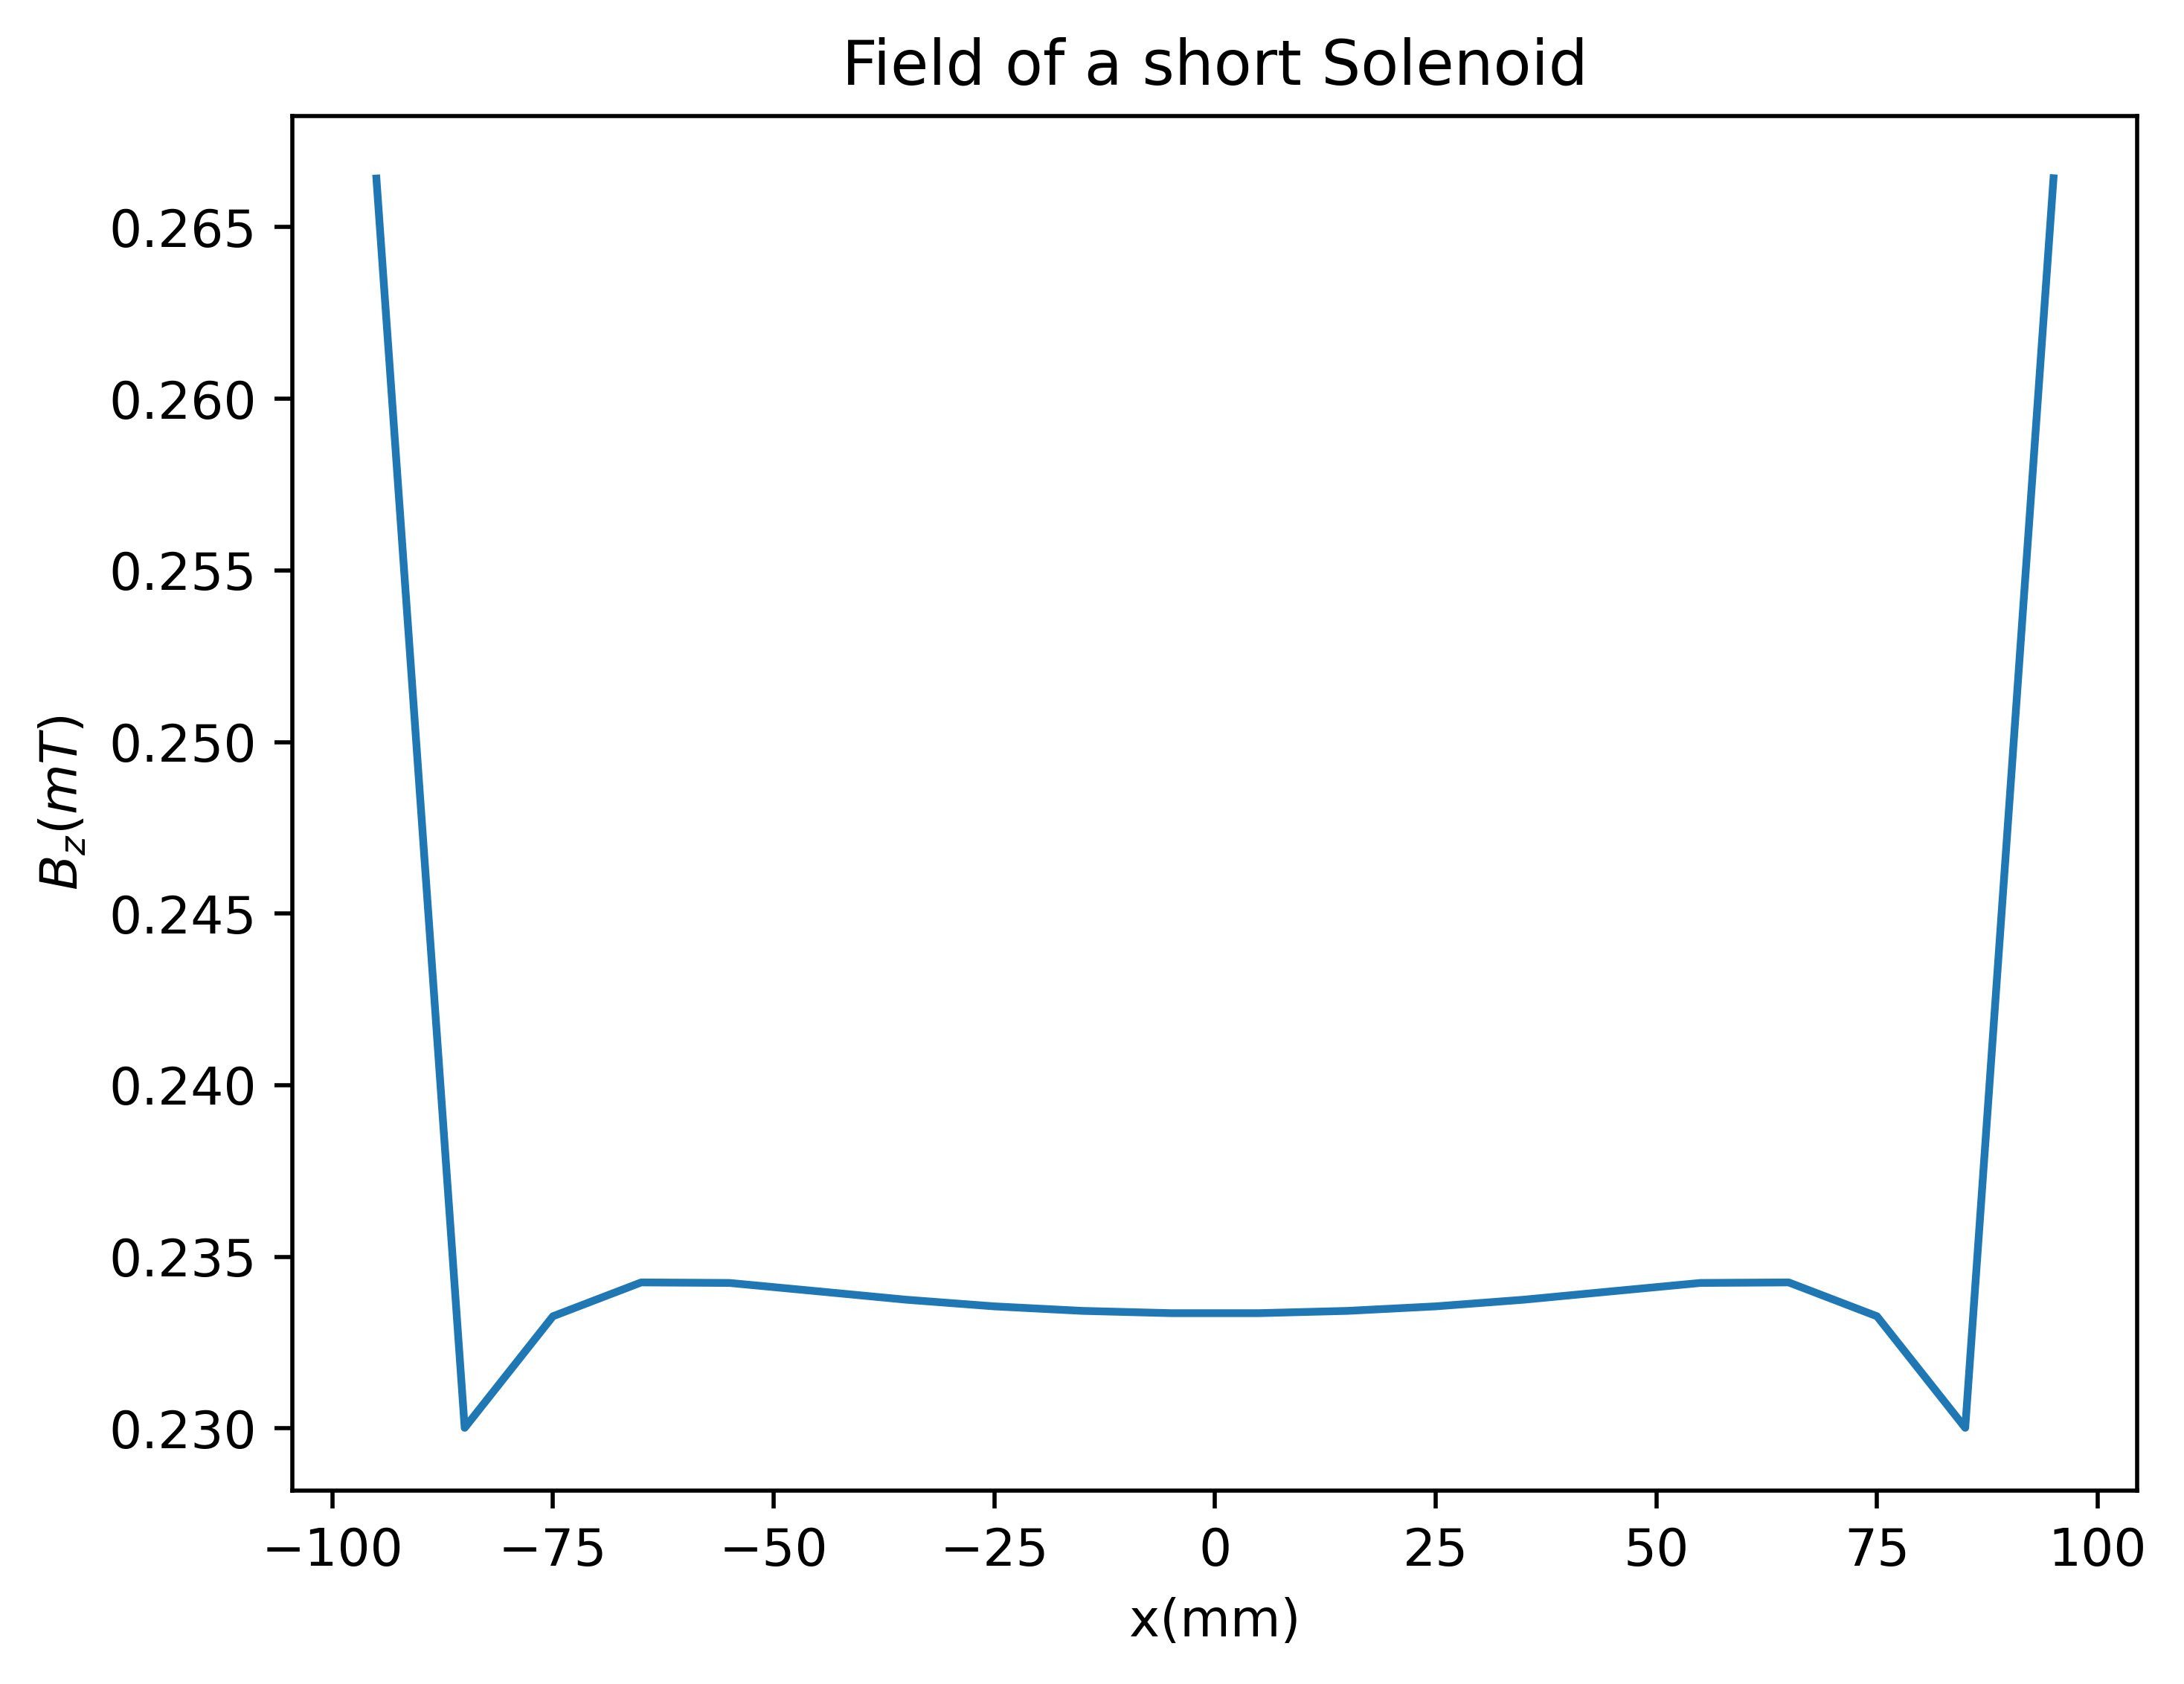

In [13]:
B_temp_sol = np.array([])
for i in np.linspace(-0.095, 0.095, 20):
    B_temp_sol = np.append(B_temp_sol, [Bsolenoid(np.array([i, 0, 0]))[2]])
%matplotlib inline
plt.figure(dpi = 500)
plt.title("Field of a short Solenoid")
plt.ylabel("$B_z(mT)$")
plt.xlabel("x(mm)")
plt.plot(1000*np.linspace(-0.095, 0.095, 20), 1000*B_temp_sol)
plt.savefig('C:\\Users\\ss\\Downloads\\Sol-Bz-x.png', facecolor = 'w', dpi = 500)
plt.show()

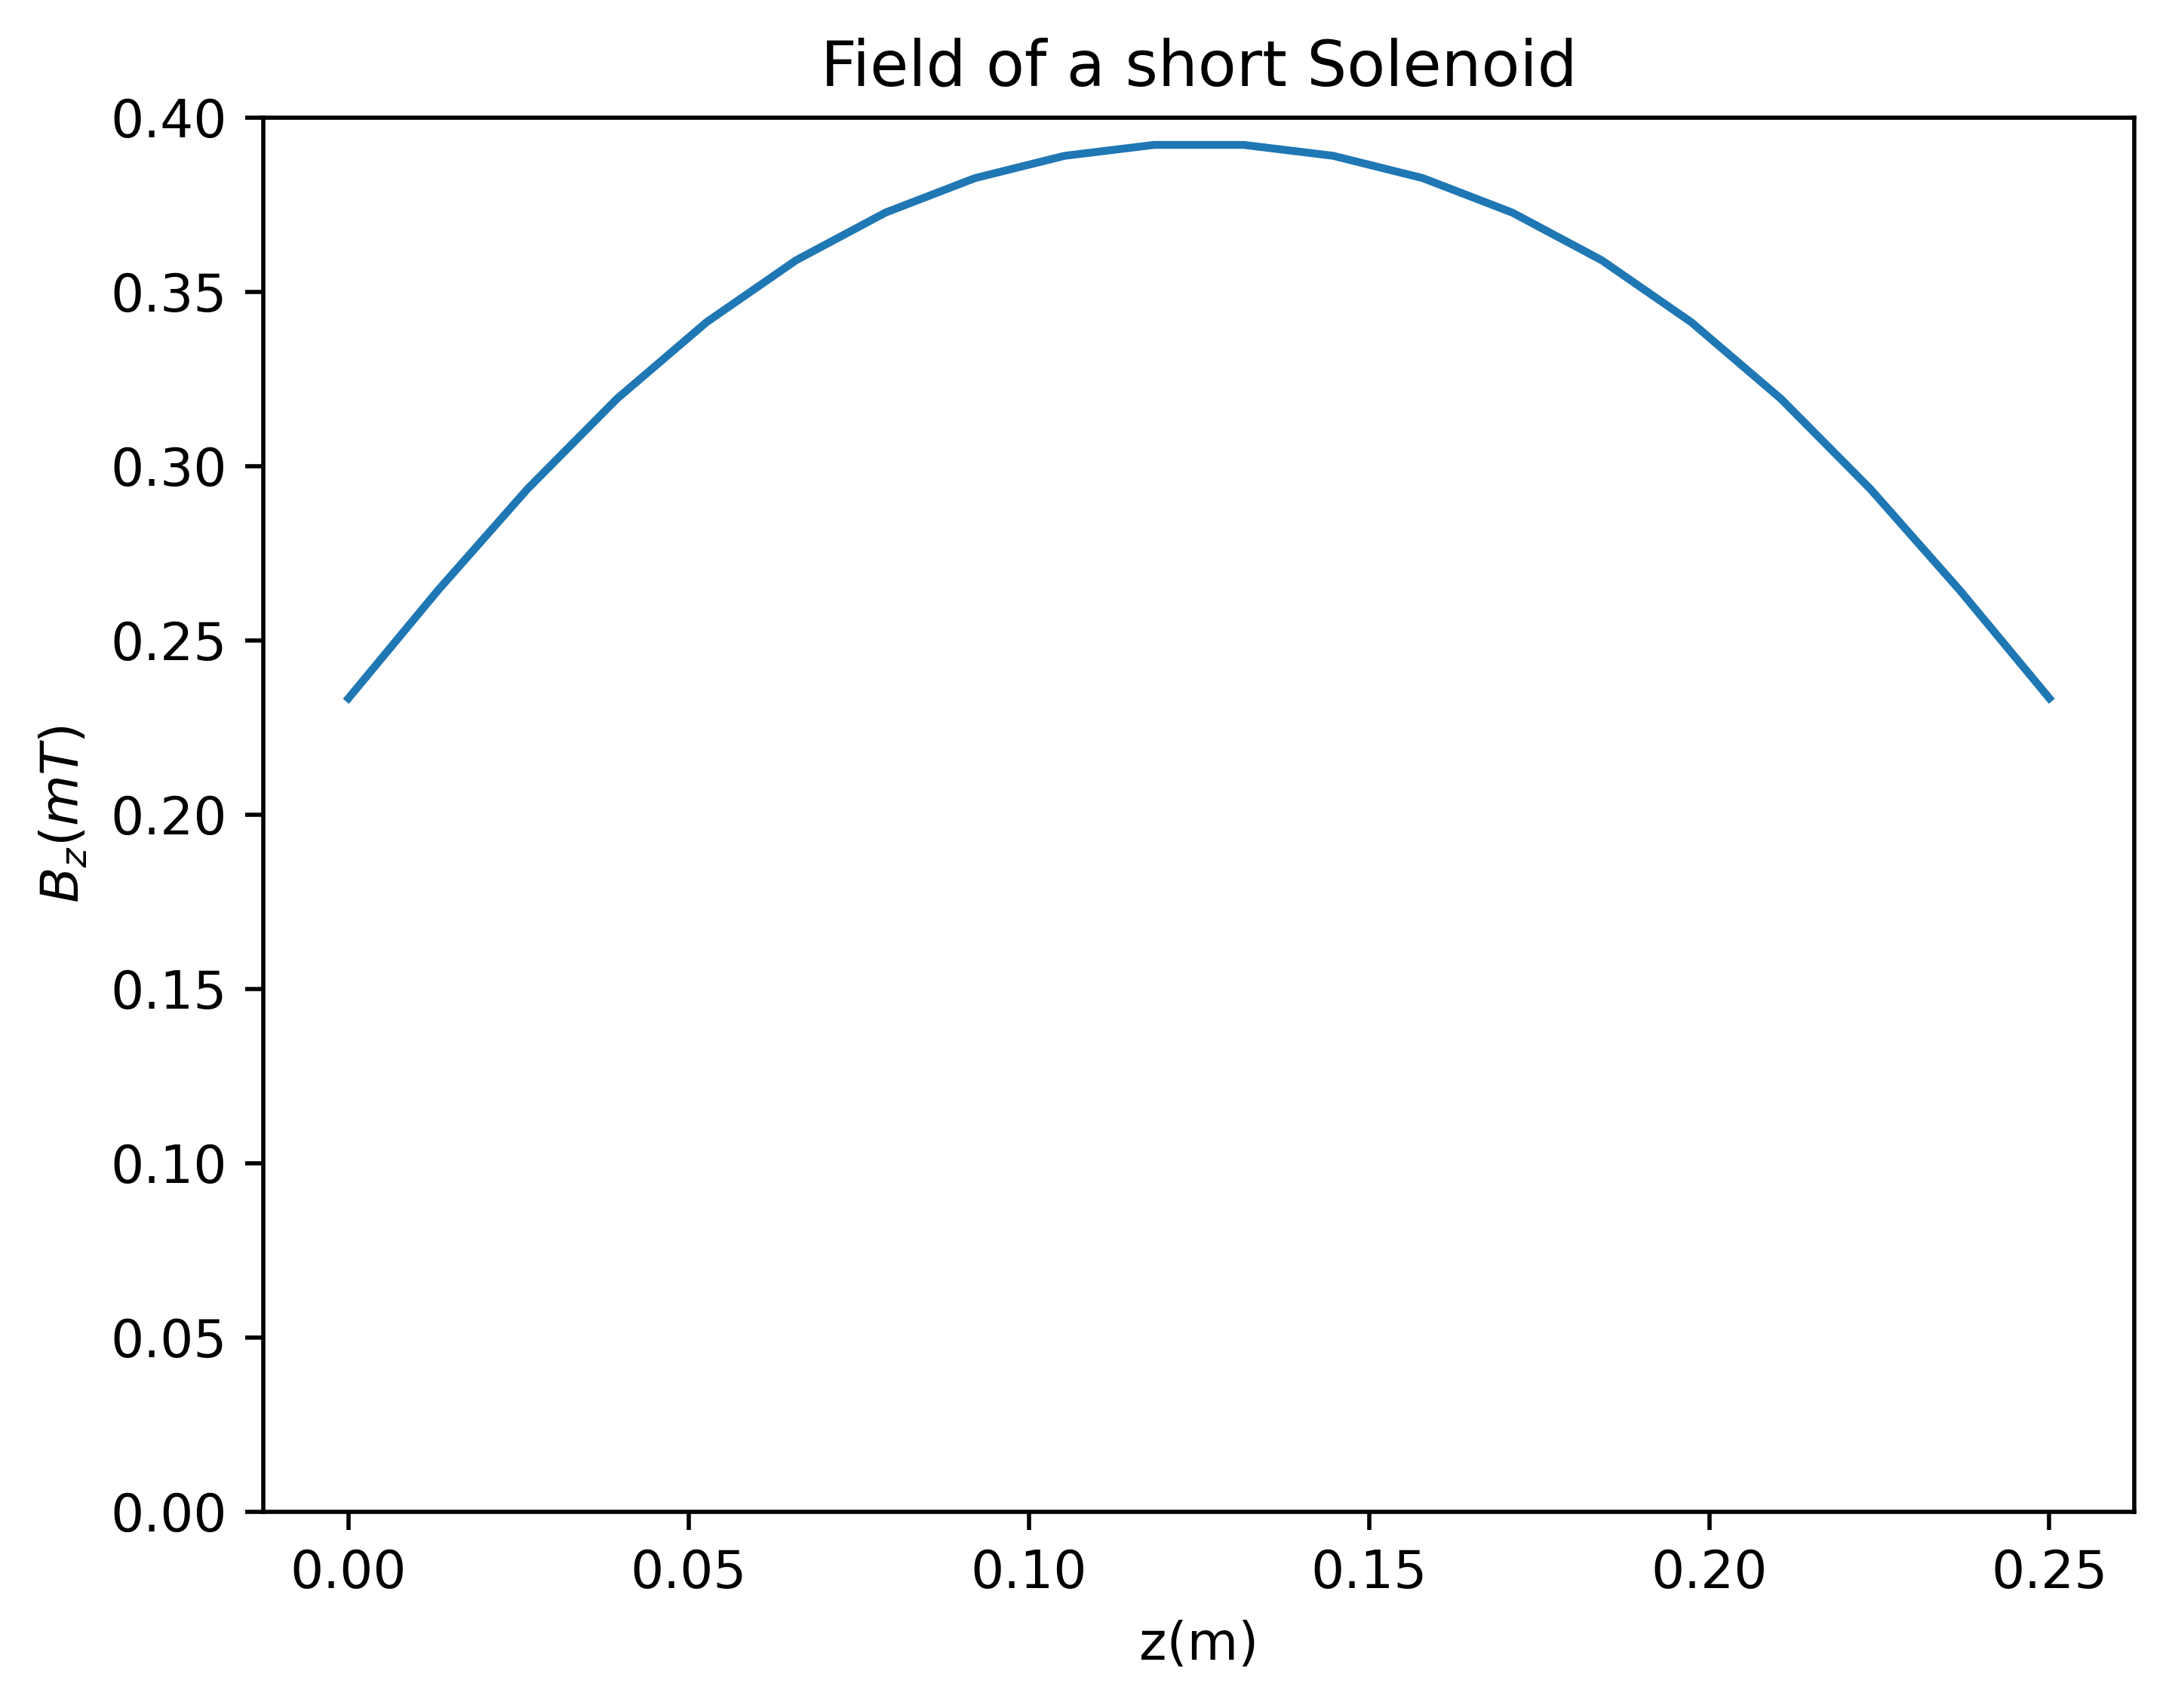

In [14]:
B_temp_sol = np.array([])
for i in np.linspace(0, .25, 20):
    B_temp_sol = np.append(B_temp_sol, [Bsolenoid(np.array([0, 0, i]))[2]])
%matplotlib inline
plt.figure(dpi = 500)
plt.title("Field of a short Solenoid")
plt.ylabel("$B_z(mT)$")
plt.xlabel("z(m)")
plt.ylim(0, 0.4)
plt.plot(np.linspace(0, 0.25, 20), 1000*B_temp_sol)
plt.savefig('C:\\Users\\ss\\Downloads\\Sol-Bz-z.png', facecolor = 'w', dpi = 500)
plt.show()

### Long Solenoid

In [15]:
%matplotlib qt
isol = 0.0
fsol = 2*np.pi
t = np.linspace(iap, fapple, 1000)
fsolx, fsoly, fsolz =  lambda t:0.1*np.cos(100*t), lambda t:0.1*np.sin(100*t), lambda t: 5*t/(8*np.pi)
Bsolenoid = lambda pos:B(pos, fsolx, fsoly, fsolz, isol, fsol, 1000)
xsol, ysol, zsol = np.meshgrid(np.linspace(-.15, .15, 8), np.linspace(-.15, .15, 8), np.linspace(-.01, 1.30, 8))
ax = plt.axes(projection = "3d")
# ax.plot(fsolx(t), fsoly(t), fsolz(t))
Bsol = np.zeros([3, 8, 8, 8])
for i in range(8):
    for j in range(8):
        for k in range(8):
            Bsol[0][i][j][k], Bsol[1][i][j][k], Bsol[2][i][j][k] = Bsolenoid(np.array([xsol[i][j][k], ysol[i][j][k], zsol[i][j][k]]))
ax.quiver(xsol, ysol, zsol, Bsol[0], Bsol[1], Bsol[2], length=1500)
plt.show()

In [16]:
np.arccos(Bsolenoid([0, 0, 0.01])[2]/np.linalg.norm(Bsolenoid([0, 0, 0.01])))

0.0020380579270714463

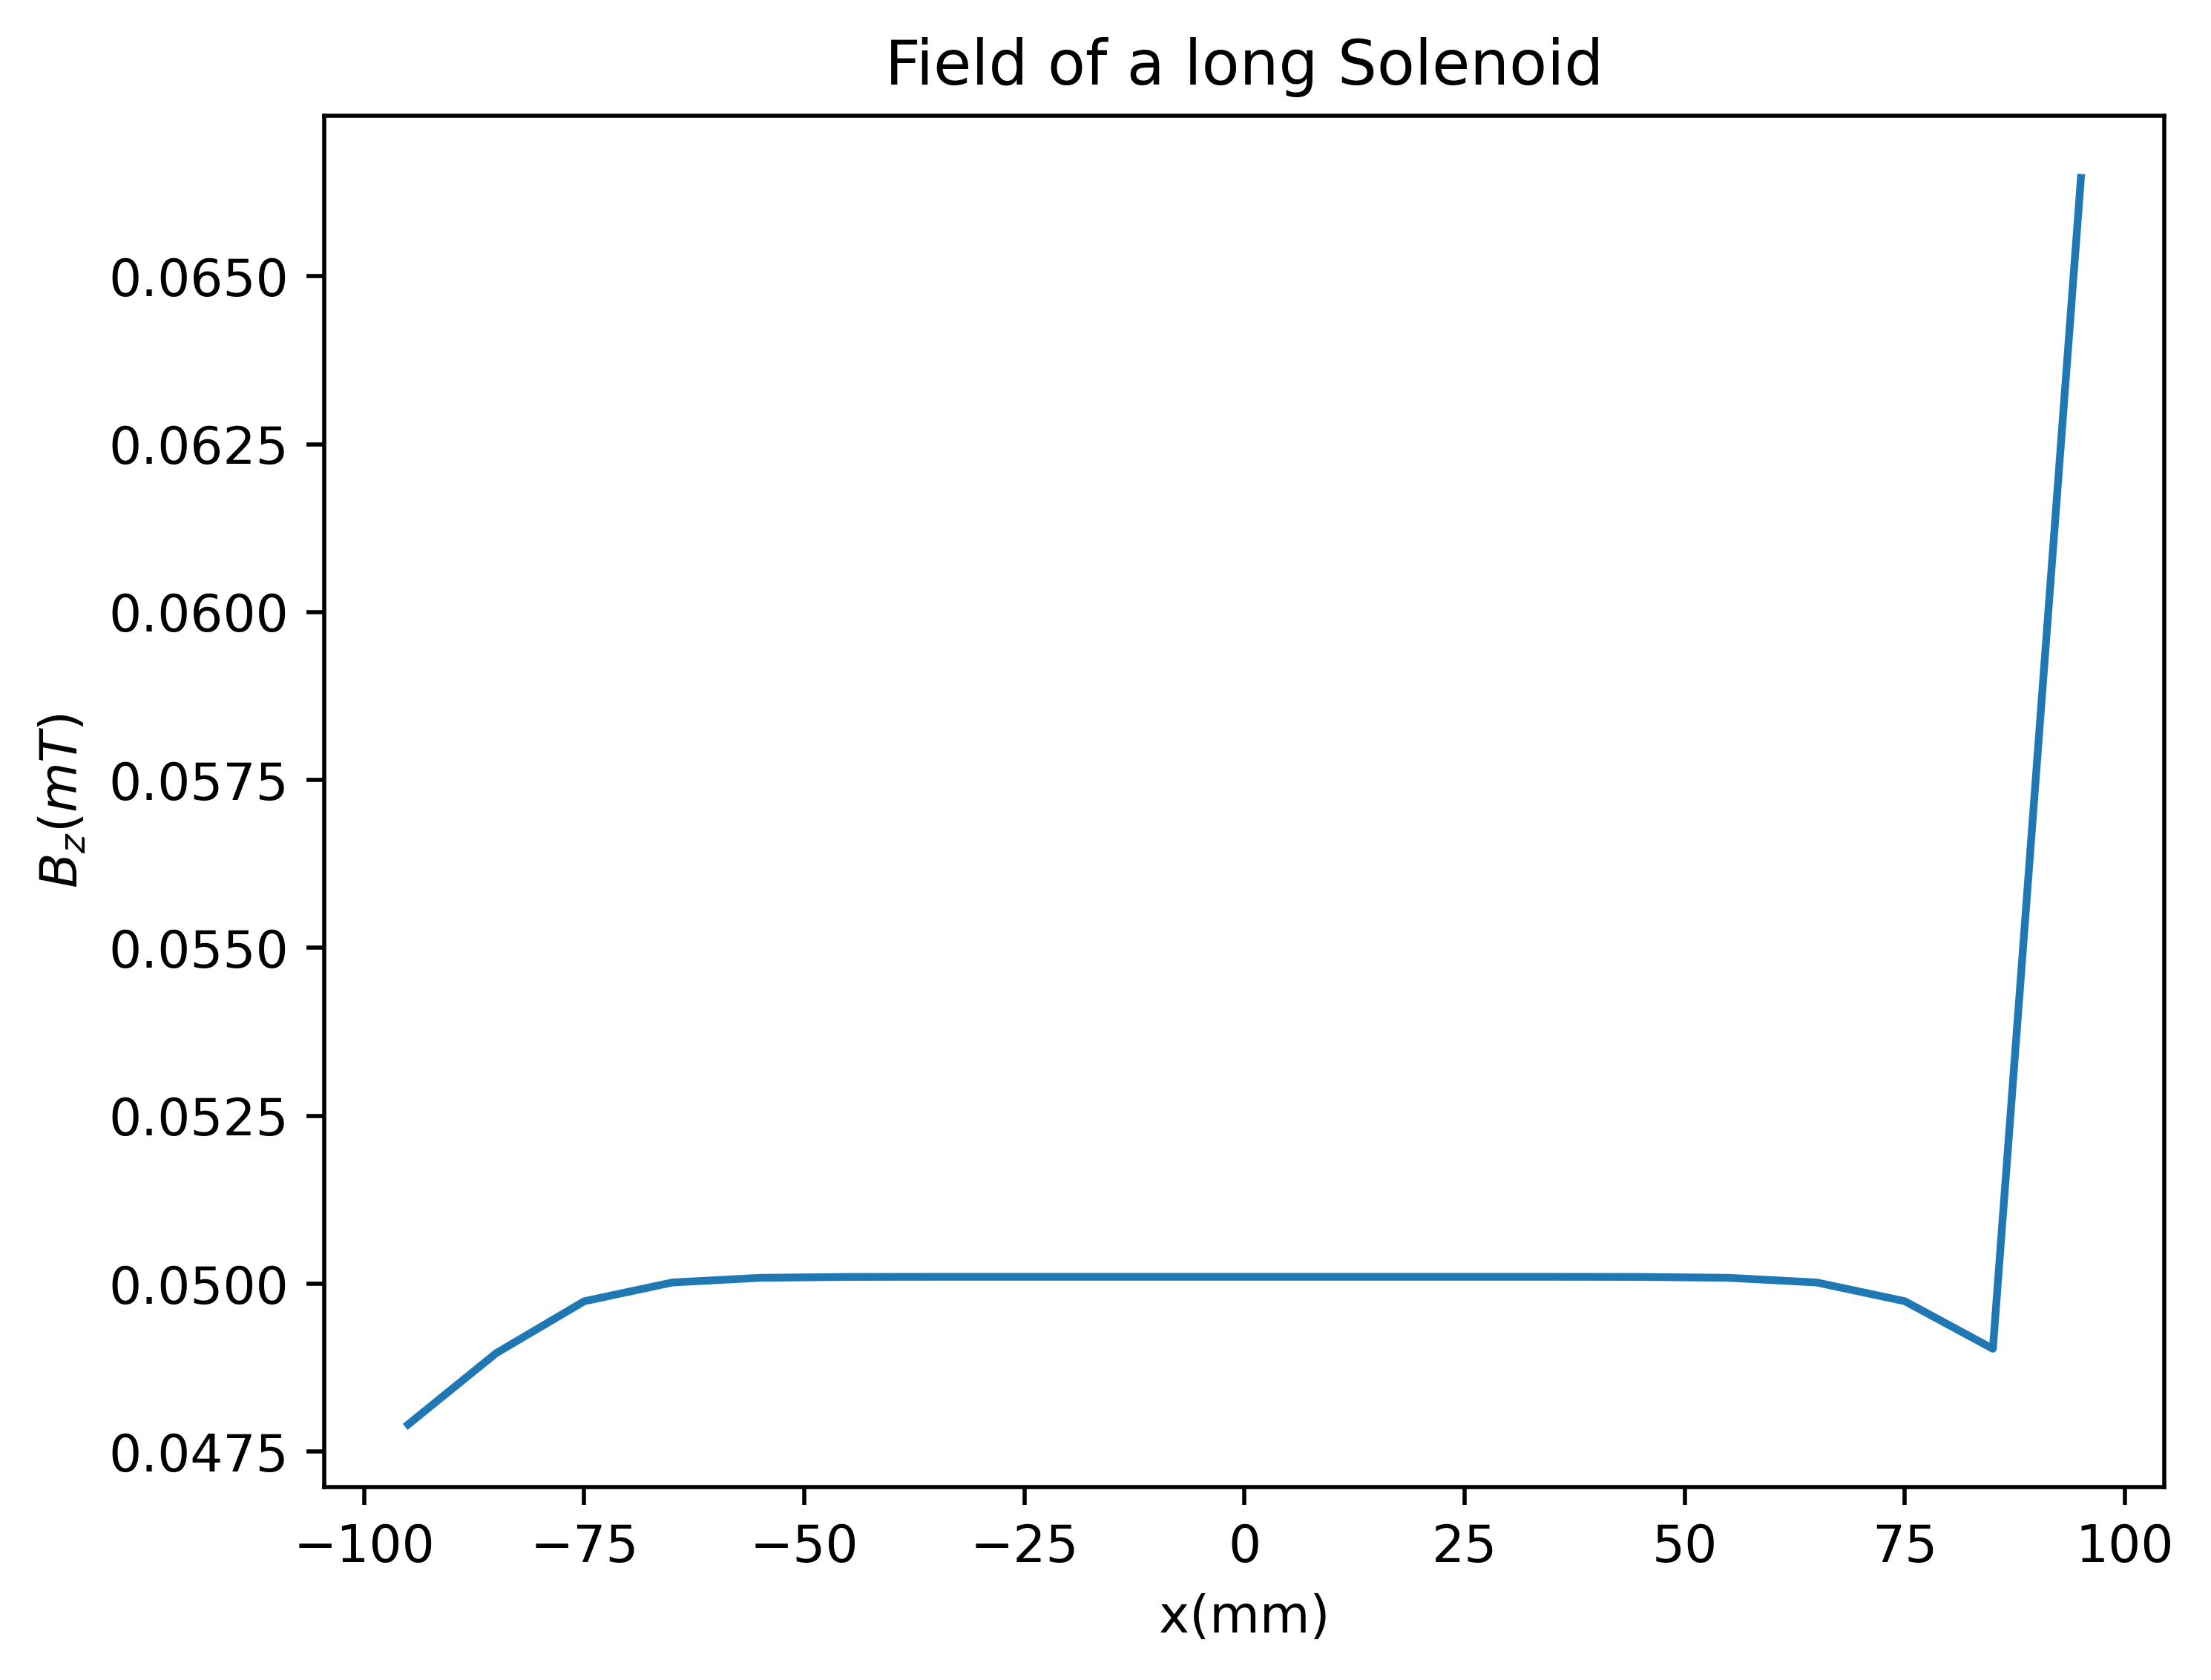

In [17]:
B_temp_sol = np.array([])
for i in np.linspace(-0.095, 0.095, 20):
    B_temp_sol = np.append(B_temp_sol, [Bsolenoid(np.array([i, 0, 0]))[2]])
%matplotlib inline
plt.figure(dpi = 500)
plt.title("Field of a long Solenoid")
plt.ylabel("$B_z(mT)$")
plt.xlabel("x(mm)")
plt.plot(1000*np.linspace(-0.095, 0.095, 20), 1000*B_temp_sol)
# plt.savefig('C:\\Users\\ss\\Downloads\\longSol-Bz-x.png', facecolor = 'w', dpi = 500)
plt.show()

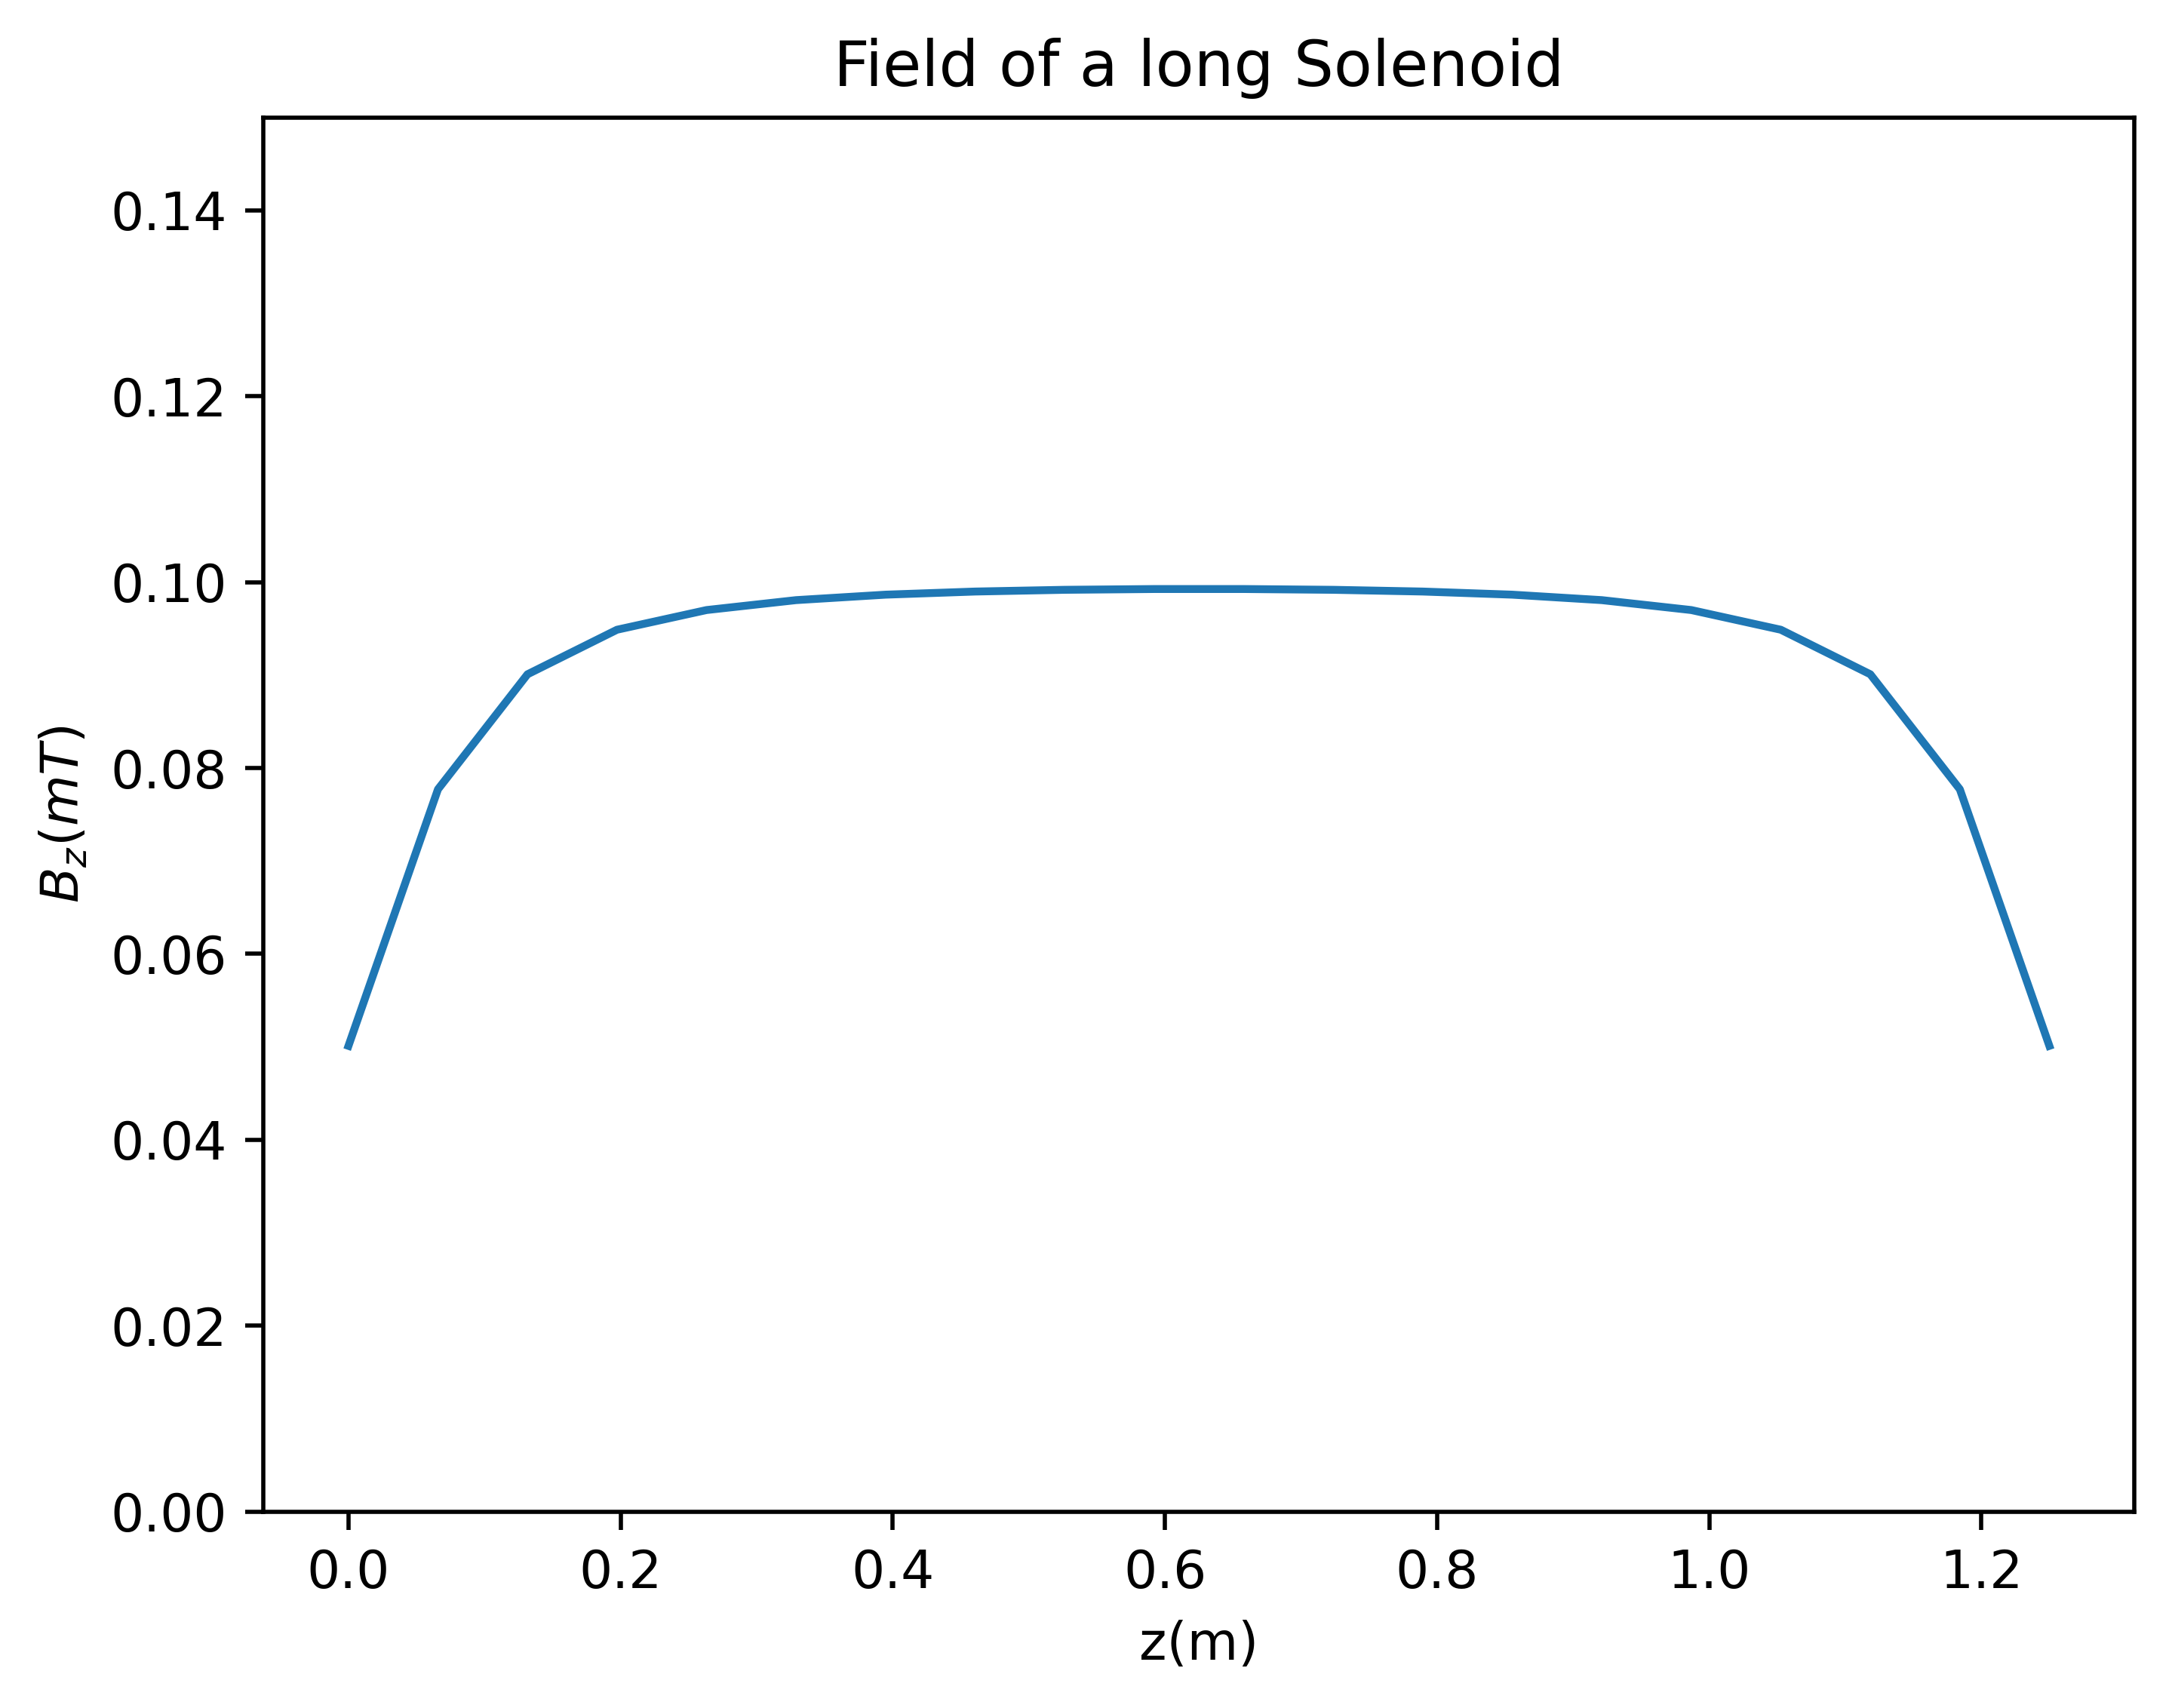

In [18]:
B_temp_sol = np.array([])
for i in np.linspace(0, 1.25, 20):
    B_temp_sol = np.append(B_temp_sol, [Bsolenoid(np.array([0, 0, i]))[2]])
%matplotlib inline
plt.figure(dpi = 500)
plt.title("Field of a long Solenoid")
plt.ylabel("$B_z(mT)$")
plt.xlabel("z(m)")
plt.ylim(0, 0.15)
plt.plot(np.linspace(0, 1.25, 20), 1000*B_temp_sol)
plt.savefig('C:\\Users\\ss\\Downloads\\longSol-Bz-z.png', facecolor = 'w', dpi = 500)
plt.show()

### Toroid

In [19]:
%matplotlib qt
itor = 0.0
ftor = 2*np.pi
t = np.linspace(itor, ftor, 10000)
ftorx = lambda t: (0.1+0.05*np.sin(200*t))*np.cos(t)
ftory = lambda t:(0.1+0.05*np.sin(200*t))*np.sin(t) 
ftorz = lambda t: 0.05*np.cos(200*t)
Btoroid = lambda pos:B(pos, ftorx, ftory, ftorz, itor, ftor, 5000)
xtor, ytor, ztor = np.meshgrid(np.linspace(-0.11, 0.11, 7), np.linspace(-0.11, 0.11, 7), np.linspace(-0.11, 0.11, 7))
ax = plt.axes(projection = "3d")
ax.plot(ftorx(t), ftory(t), ftorz(t))
plt.show()

In [20]:
%matplotlib qt
ax = plt.axes(projection = "3d")
Btor = np.zeros([3, 7, 7, 7])
for i in range(7):
    for j in range(7):
        for k in range(7):
            Btor[0][i][j][k], Btor[1][i][j][k],Btor[2][i][j][k] = Btoroid(np.array([xtor[i][j][k], ytor[i][j][k], ztor[i][j][k]]))
            length = np.linalg.norm(np.array([Btor[0][i][j][k], Btor[1][i][j][k],Btor[2][i][j][k]]))
            if length > 1e-4: 
                Btor[0][i][j][k]/= length
                Btor[1][i][j][k]/= length
                Btor[2][i][j][k]/= length
                Btor[0][i][j][k]*= 1e-5
                Btor[1][i][j][k]*= 1e-5
                Btor[2][i][j][k]*= 1e-5
ax.quiver(xtor, ytor, ztor, Btor[0], Btor[1], Btor[2], length = 10000)
plt.show()

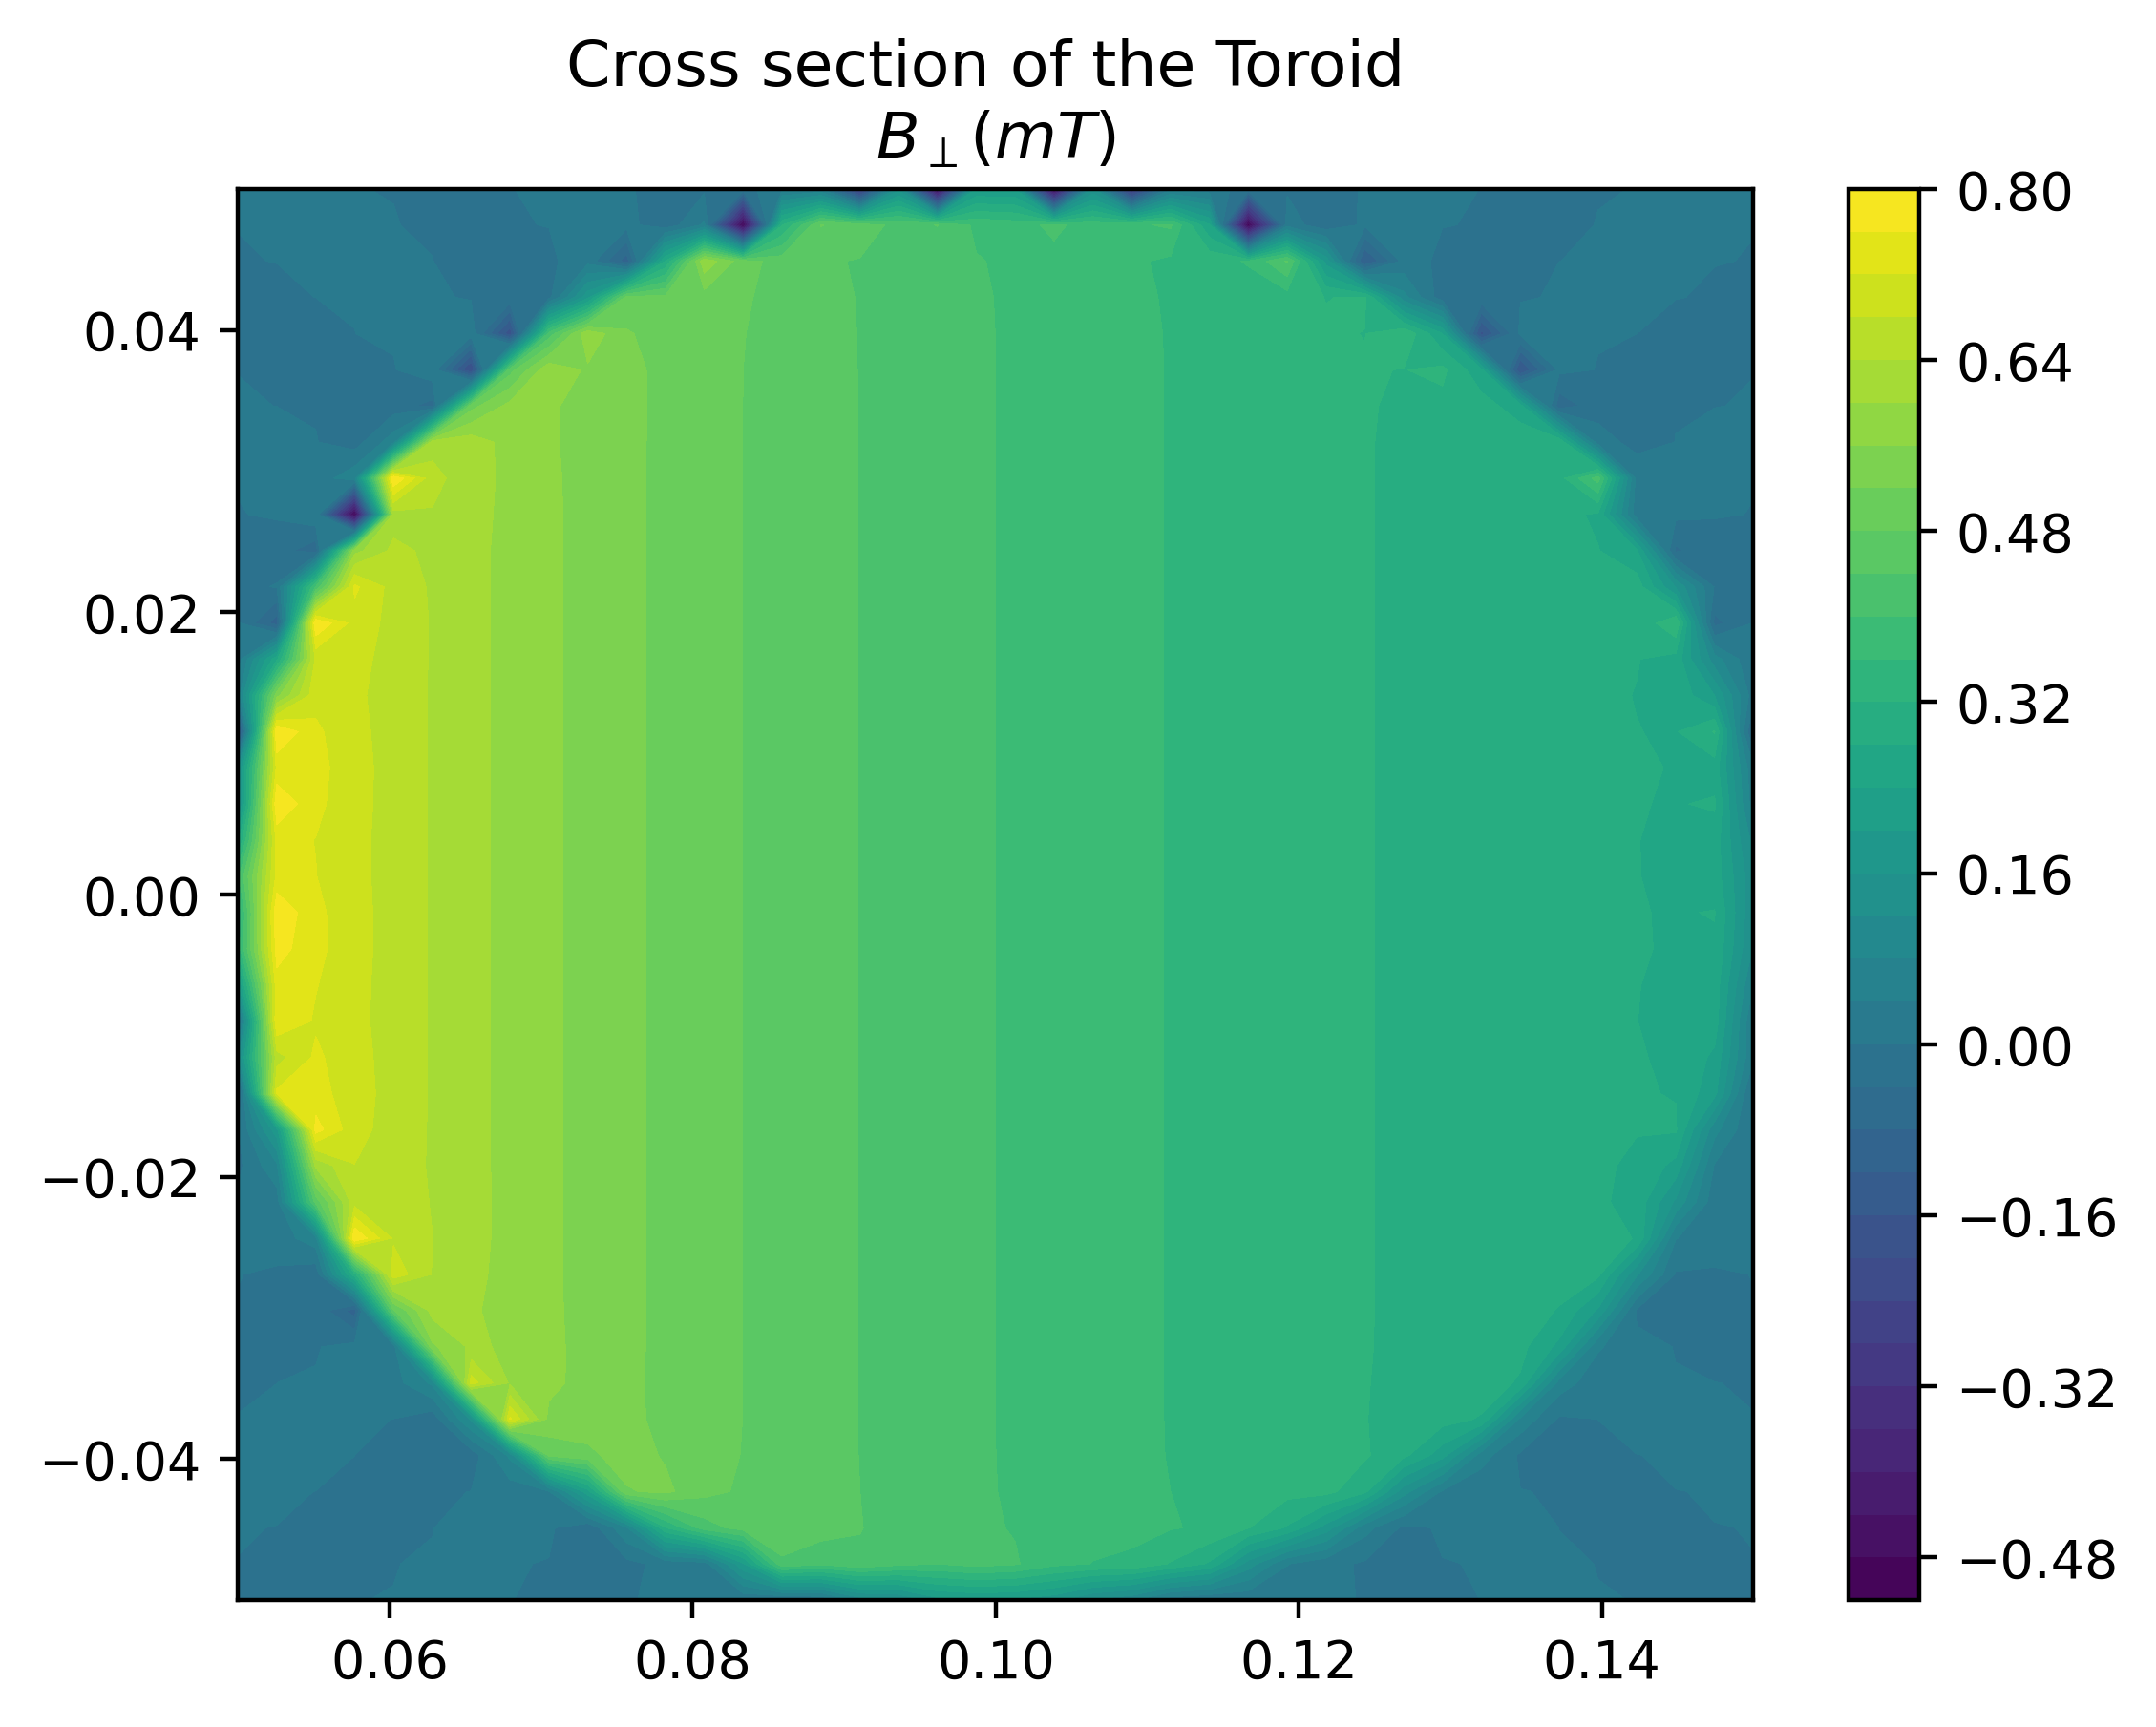

In [21]:
%matplotlib inline
crosssecplt = np.zeros((40, 40))
x_cross_sec, y_cross_sec = np.meshgrid(np.linspace(0.05, 0.15, 40), np.linspace(-0.05, 0.05, 40))
for x_i in range(40):
    for z_i in range(40):
        crosssecplt[x_i][z_i] = sorted([0.0008, Btoroid(np.array([x_cross_sec[x_i][z_i], 0, y_cross_sec[x_i][z_i]]))[1], -0.0005])[1]
plt.figure(dpi = 400)
plt.title("Cross section of the Toroid \n$B_{\perp}(mT)$")
plt.contourf(x_cross_sec, y_cross_sec, 1000*crosssecplt, levels = 40)
plt.colorbar()
plt.savefig('C:\\Users\\ss\\Downloads\\Tor-Cross_sec_field.png', facecolor = 'w', dpi = 500)
plt.show()

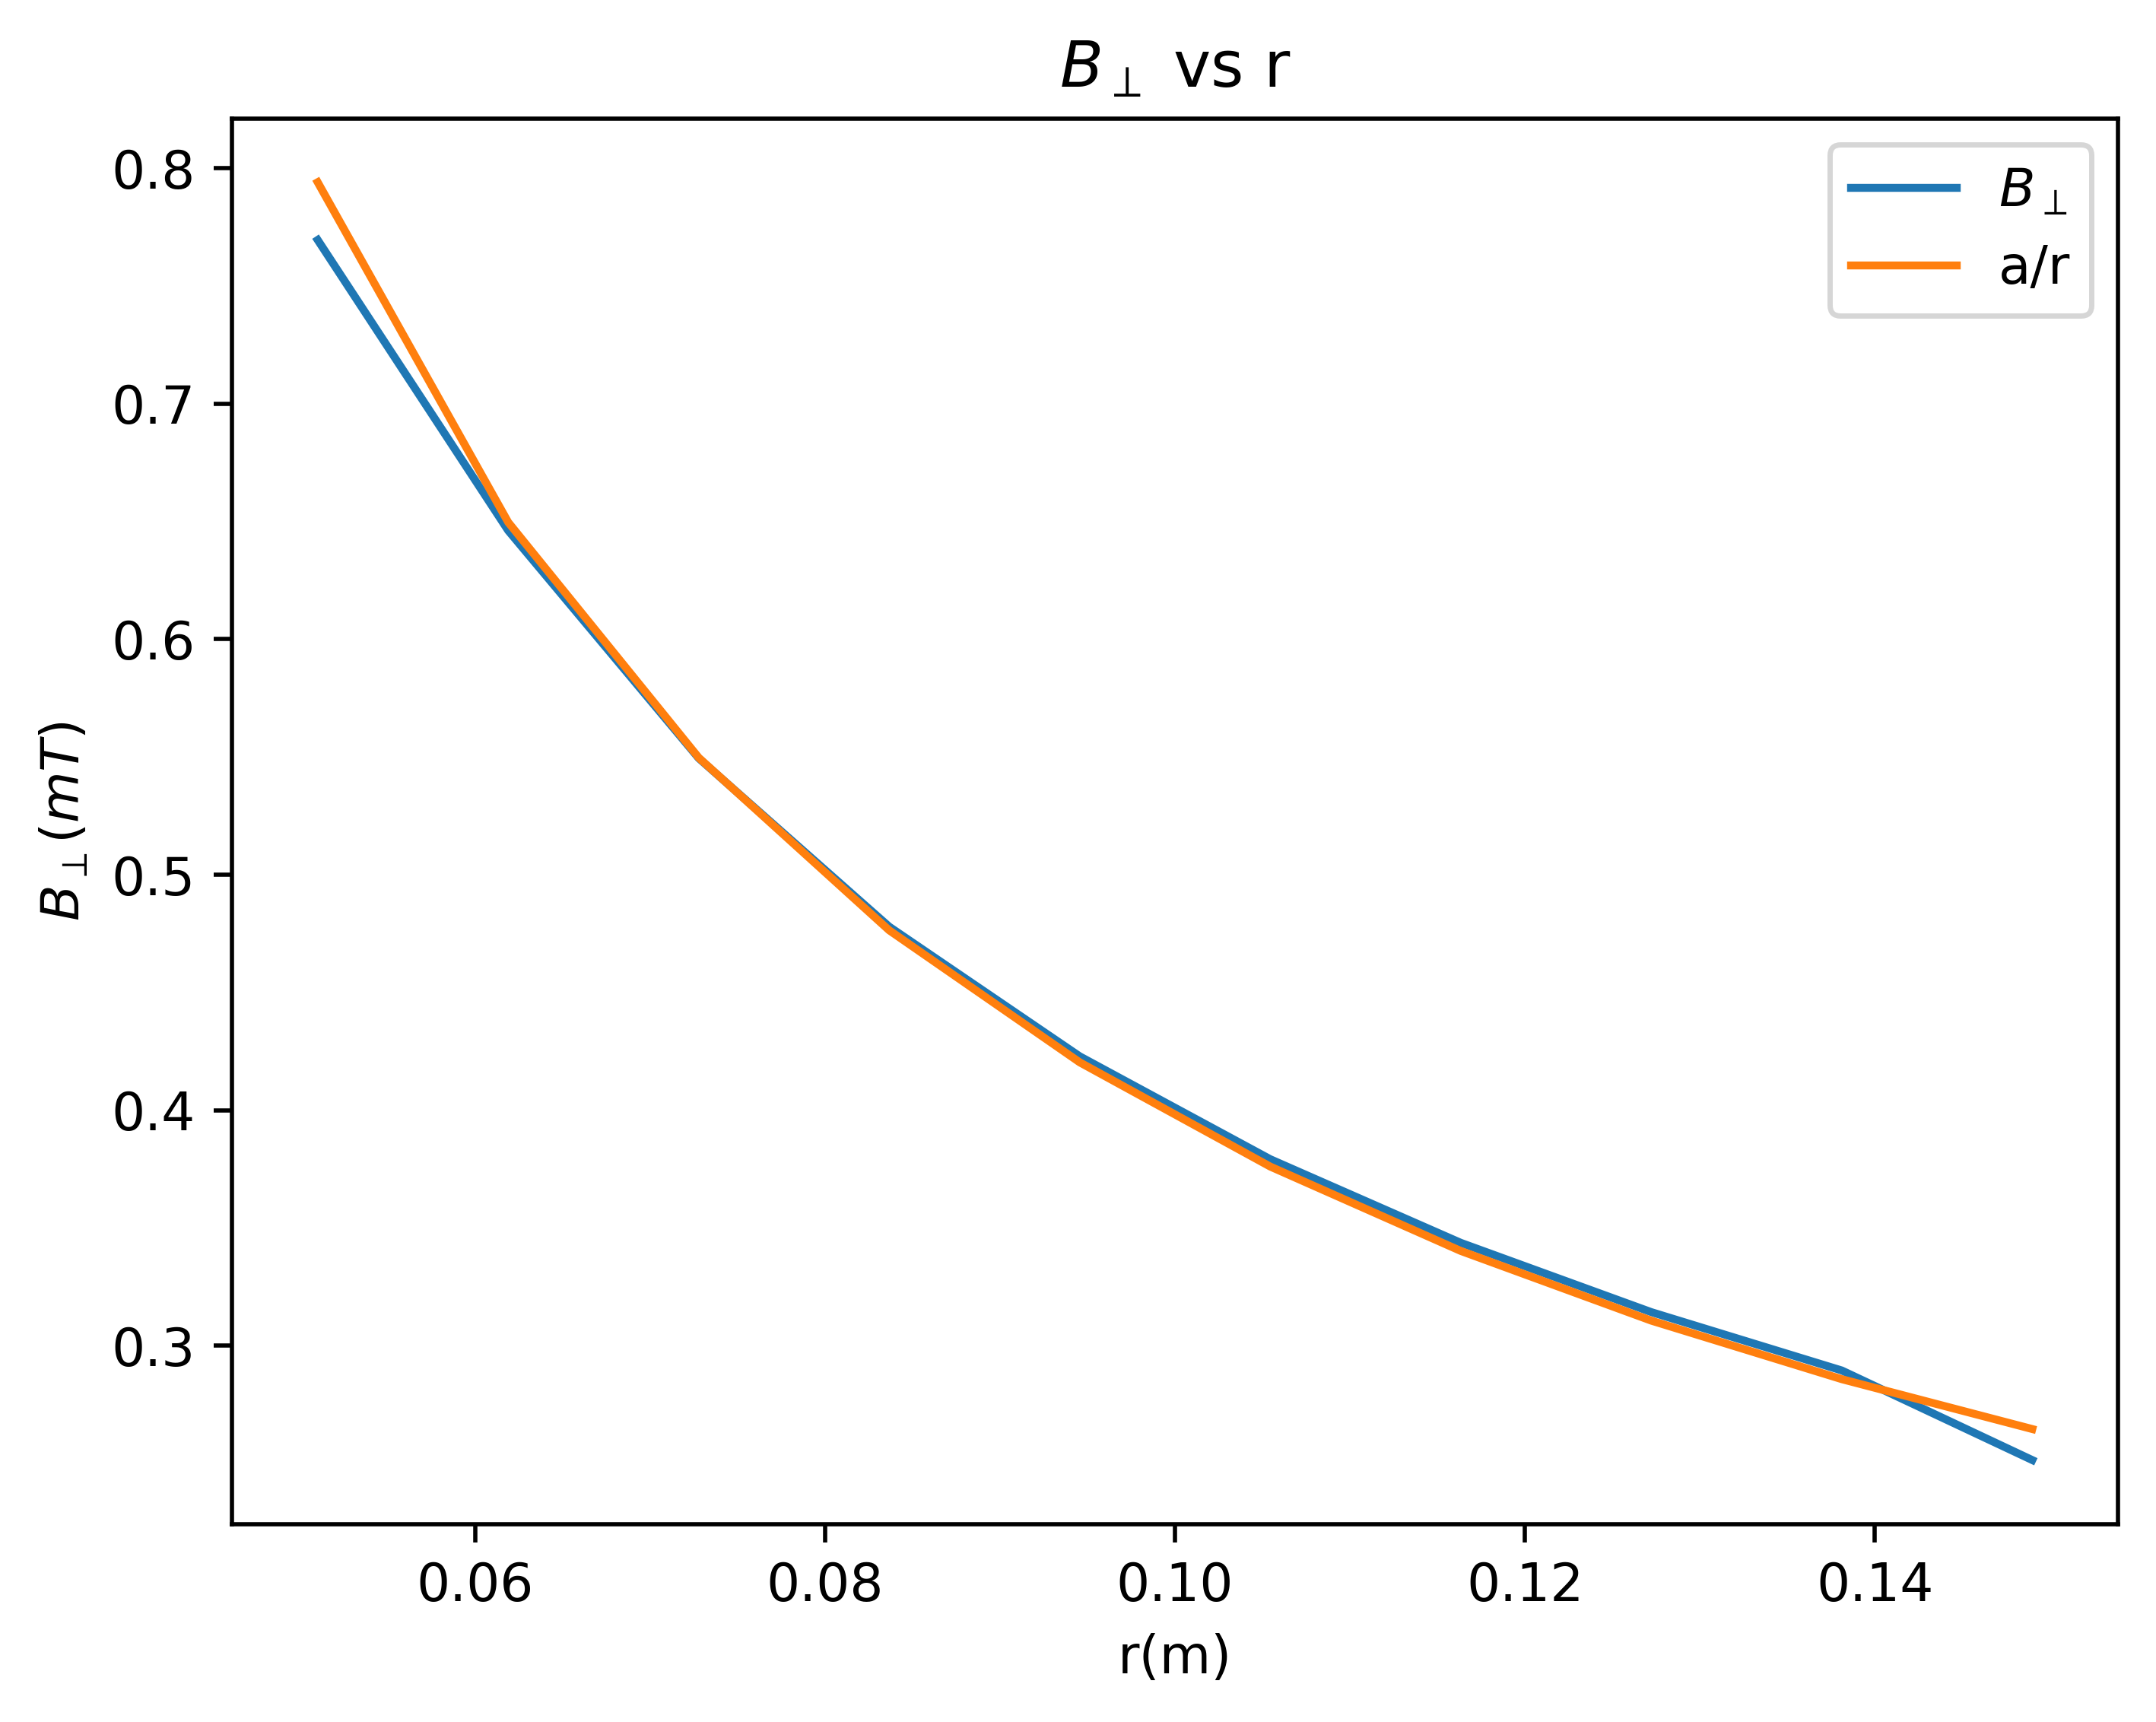

In [22]:
B_temp = np.array([])
for i in np.linspace(0.051, 0.149, 10):
    B_temp = np.append(B_temp, [Btoroid(np.array([i, 0, 0]))[1]])

%matplotlib inline
plt.figure(dpi = 500)
plt.tight_layout()
plt.title("$B_{\perp}$ vs r")
plt.ylabel("$B_{\perp}(mT)$")
plt.xlabel("r(m)")
plt.plot(np.linspace(0.051, 0.149, 10), 1000*B_temp, label = "$B_{\perp}$")
plt.plot(np.linspace(0.051, 0.149, 10), 3.97e-2/np.linspace(0.05, 0.15, 10), label = "a/r")
plt.savefig('C:\\Users\\ss\\Downloads\\Tor-perp_field_gradient.png', facecolor = 'w', dpi = 500)
plt.legend()
plt.show()

In [1]:
%conda install cython

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ss\anaconda3

  added / updated specs:
    - cython


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.11.1              |   py39haa95532_4         892 KB
    ruamel.yaml-0.17.21        |   py39h2bbff1b_0         174 KB
    ruamel.yaml.clib-0.2.6     |   py39h2bbff1b_1         101 KB
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

  ruamel.yaml        pkgs/main/win-64::ruamel.yaml-0.17.21-py39h2bbff1b_0
  ruamel.yaml.clib   pkgs/main/win-64::ruamel.yaml.clib-0.2.6-py39h2bbff1b_1

The following packages will be UPDATED:

  conda                               4.14.0-py39haa95532_0 --> 22.11.1-py39haa95532_4




ruamel.yaml.clib-0.2 | 101 KB    |            |   0